In [1]:
# -*- coding: utf-8 -*-
import h5py
import os
import pickle
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.metrics.functional.classification import auroc, stat_scores
from sklearn.metrics import roc_auc_score

In [54]:
import argparse
args = argparse.Namespace(mri_sequences='ABDEFKT', data_sequences='TBAKDEF')
alls = [f'results/wang-fold-f32-all/{run}/checkpoints/best_model.ckpt' for run in ['b34nhcv0', '33buc5r8', '3c2gse8e', '2r1z4cwj', '26rnunc9']]
bals = [f'results/wang-fold-f32-bal/{run}/checkpoints/best_model.ckpt' for run in ['2i6cmcxi', '1yoi682c', '255zng2j', '397n7wvh', '16jo7a6s']]
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-msin-bal/28pu6b6l/checkpoints/best_model.ckpt' # apricot-pyramid-1084
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-msin-all/3ru4qlz1/checkpoints/best_model.ckpt' # peach-planet-1085
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-fold-bal/z4ktwfw9/checkpoints/epoch=102-valid_acc=0.81.ckpt'
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-fold-all/1r28mhqt/checkpoints/epoch=125-valid_acc=0.81.ckpt'
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-fold-4-all/1vz35wtb/checkpoints/epoch=306-valid_auc=0.85.ckpt'
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-all-sweep-2/05m88fdq/checkpoints/epoch=395-valid_auc=0.99.ckpt'
# ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-all-sweep/n0l6u70s/checkpoints/epoch=111-valid_auc=0.84.ckpt' # astral-sweep-1
# msin = 'results/wang-msin-fold-bal/q0julcgq/checkpoints/best_model.ckpt' # deft-feather-1049, fold 4
# pzn = 'results/wang-pzn-fold-bal/333nt7mb/checkpoints/best_model.ckpt' # generous-universe-1065, fold 1
# tzn = 'results/wang-tzn-fold-bal/2w061stf/checkpoints/best_model.ckpt' # worthy-brook-1069, fold 2
# ckpt = msin
# sd = torch.load(ckpt, map_location=torch.device('cpu'))
# if 'w_ensemble' not in sd['state_dict']:
    # sd['state_dict']['w_ensemble'] = torch.tensor([1 / (model.num_sequences + 1)] * (model.num_sequences + 1)) 
# sd['epoch']
sds = [torch.load(ckpt, map_location=torch.device('cpu')) for ckpt in alls + bals]
print([sd['epoch'] for sd in sds])
[sd['hyper_parameters']['valid_dir'] for sd in sds]

[172, 171, 117, 194, 43, 182, 195, 35, 47, 31]


['tbakd3_npy/5folds/0/valid',
 'tbakd3_npy/5folds/1/valid',
 'tbakd3_npy/5folds/2/valid',
 'tbakd3_npy/5folds/3/valid',
 'tbakd3_npy/5folds/4/valid',
 'tbakd3_npy/5folds/0/valid',
 'tbakd3_npy/5folds/1/valid',
 'tbakd3_npy/5folds/2/valid',
 'tbakd3_npy/5folds/3/valid',
 'tbakd3_npy/5folds/4/valid']

In [10]:
from wang_args import WangClassifier
# msin, pzn, tzn = (WangClassifier.load_from_checkpoint(ckpt) for ckpt in [msin, pzn, tzn])
# model = WangClassifier.load_from_checkpoint(ckpt, **vars(args))
malls = [WangClassifier.load_from_checkpoint(ckpt, **vars(args)) for ckpt in alls]
mbals = [WangClassifier.load_from_checkpoint(ckpt, **vars(args)) for ckpt in bals]
_ = [model.eval() for model in malls + mbals]
# model.w_ensemble
# model = WangClassifier(**vars(args))
# model.load_state_dict(sd['state_dict'])
# _ = msin.eval()
# msin.w_ensemble


  | Name   | Type       | Params
--------------------------------------
0 | conv   | ModuleList | 30.8 K
1 | linear | ModuleList | 29.6 K
2 | fusion | Sequential | 28.8 K
--------------------------------------
89.2 K    Trainable params
0         Non-trainable params
89.2 K    Total params

  | Name   | Type       | Params
--------------------------------------
0 | conv   | ModuleList | 30.8 K
1 | linear | ModuleList | 29.6 K
2 | fusion | Sequential | 28.8 K
--------------------------------------
89.2 K    Trainable params
0         Non-trainable params
89.2 K    Total params

  | Name   | Type       | Params
--------------------------------------
0 | conv   | ModuleList | 30.8 K
1 | linear | ModuleList | 29.6 K
2 | fusion | Sequential | 28.8 K
--------------------------------------
89.2 K    Trainable params
0         Non-trainable params
89.2 K    Total params

  | Name   | Type       | Params
--------------------------------------
0 | conv   | ModuleList | 30.8 K
1 | linear | Modul

In [35]:
tbl_perfs = []
for i, model in enumerate(malls):
    b, y = next(iter(model.val_dataloader()))
    l = model(b[:, model.mri_index])
    p = torch.sigmoid(l) * 0
    # print(model.criterion(l, y.float()))
    m = model.metrics(p.matmul(model.w_ensemble), y)
    ms = [model.metrics(p[:, i], y) for i in range(p.shape[1])]
    mw0 = model.metrics(p.matmul(torch.tensor([1 / (model.num_sequences + 1)] * (model.num_sequences + 1))), y)
    # print("W_en: " + ", ".join(map(lambda x:f"{x:.4f}", model.w_ensemble)))
    # print("Pred: " + "".join(map(str, m['pred'].tolist())))
    # print("True: " + "".join(map(str, y.tolist())))
    # print(mw0['auc'], mw0['acc'])
    tbl_perf = np.array(list(map(lambda x:[x[k] for k in list(m.keys())[1:]], np.array(ms + [m]))))
    tbl_perfs.append(tbl_perf)
    # df_perf = pd.DataFrame(tbl_perf.round(4), columns=list(m.keys())[1:])
    # df_perf.index = list(model.mri_sequences + 'NE')
    # df_perf.to_csv('i.csv')
    # df_perf


In [55]:
tbl_mean, tbl_std = np.asarray(tbl_perfs).mean(axis=0), np.asarray(tbl_perfs).std(axis=0)
df_mean = pd.DataFrame(tbl_mean.round(4), columns=list(m.keys())[1:])
df_mean.index = list(model.mri_sequences + 'NE')
df_std = pd.DataFrame(tbl_std.round(4), columns=list(m.keys())[1:])
df_std.index = list(model.mri_sequences + 'NE')
df_mean

,auc,acc,tpr,tnr,ppv,f1
A,0.5,0.7681,0.0,1.0,NaN,0.0
B,0.5,0.7681,0.0,1.0,NaN,0.0
D,0.5,0.7681,0.0,1.0,NaN,0.0
E,0.5,0.7681,0.0,1.0,NaN,0.0
F,0.5,0.7681,0.0,1.0,NaN,0.0
K,0.5,0.7681,0.0,1.0,NaN,0.0
T,0.5,0.7681,0.0,1.0,NaN,0.0
N,0.5,0.7681,0.0,1.0,NaN,0.0
E,0.5,0.7681,0.0,1.0,NaN,0.0


In [37]:
f4 = np.vectorize(lambda x: f'{x:.4f}')
f4(tbl_perfs[3])

array([['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000'],
       ['0.5000', '0.7656', '0.0000', '1.0000', 'nan', '0.0000']],
      dtype='<U6')

In [4]:
dataset = torchvision.datasets.DatasetFolder('tbakd3_npy/test', extensions='npy', loader=np.load, transform=transforms.ToTensor())
alltest = torch.cat([x[0].unsqueeze(0) for x in dataset], 0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), drop_last=False, shuffle=False)
pred = torch.sigmoid(model(next(iter(dataloader))[0][:, model.mri_index])).matmul(model.w_ensemble).detach().numpy().round(4)
df_pred = pd.DataFrame(pred, columns=["pred"])
df_pred

,pred
0,0.3056
1,0.8494
2,0.2089
3,0.2695
4,0.2679
...,...
203,0.2684
204,0.2778
205,0.2253
206,0.2232


In [5]:
df_pred.to_csv('tmp.csv')


In [ ]:
# train_findings = pickle.load(open('tbakd3_npy/findings.pkl', "rb"))
# images, labels = pickle.load(open('tbakd3_npy/train.pkl', "rb"))
# images, labels = torch.FloatTensor(images), torch.LongTensor(labels)
# pzn_index = [i for i, k in enumerate(train_findings.keys()) if train_findings[k]['zone'] == b'PZ']
# tzn_index = [i for i, k in enumerate(train_findings.keys()) if train_findings[k]['zone'] == b'TZ']
# msin_index = range(len(images))
# model = pzn
# index = pzn_index
# b, y = images[index], labels[index]

In [188]:
msin_pred = torch.sigmoid(msin(next(iter(dataloader))[0][:, msin.mri_index])).matmul(msin.w_ensemble).detach().numpy().round(4)
pzn_pred = torch.sigmoid(pzn(next(iter(dataloader))[0][:, pzn.mri_index])).matmul(pzn.w_ensemble).detach().numpy().round(4)
tzn_pred = torch.sigmoid(tzn(next(iter(dataloader))[0][:, tzn.mri_index])).matmul(tzn.w_ensemble).detach().numpy().round(4)

In [189]:
df_pred = pd.DataFrame(np.vstack([msin_pred, msin_pred, pzn_pred, tzn_pred]).T, columns=["pred", "msin", "pzn", "tzn"])
df_pred

,pred,msin,pzn,tzn
0,0.5011,0.5011,0.6043,0.4357
1,0.8452,0.8452,0.7804,0.5746
2,0.4084,0.4084,0.4632,0.2853
3,0.4375,0.4375,0.4815,0.4984
4,0.3117,0.3117,0.2518,0.3385
...,...,...,...,...
203,0.5263,0.5263,0.7416,0.3247
204,0.3151,0.3151,0.4500,0.2985
205,0.3337,0.3337,0.5712,0.4360
206,0.3552,0.3552,0.4356,0.3507


In [190]:
test_findings = pickle.load(open('tbakd3_npy/test.pkl', "rb"))
df_pred['zone'] = [test_findings[k]['zone'] for k in test_findings]
pzn_index = df_pred[df_pred['zone'] == b'PZ'].index
tzn_index = df_pred[df_pred['zone'] == b'TZ'].index
df_pred['pred'].iloc[pzn_index] = df_pred['pzn'][pzn_index]
df_pred['pred'].iloc[tzn_index] = df_pred['tzn'][tzn_index]


In [191]:
print("Pred: \n" + "\n".join(df_pred['pred'].apply(lambda x: f"{x:.4f}")))

Pred: 
0.4357
0.7804
0.4632
0.4815
0.2518
0.5850
0.5563
0.7244
0.7422
0.7940
0.8269
0.4356
0.4679
0.8253
0.6164
0.3318
0.2704
0.4083
0.3873
0.7127
0.8052
0.5043
0.2938
0.2822
0.8072
0.2583
0.3202
0.3620
0.5986
0.2751
0.7716
0.3290
0.3948
0.3638
0.5663
0.2782
0.6829
0.4050
0.6241
0.4031
0.4776
0.2198
0.4880
0.4675
0.7213
0.2647
0.4325
0.3814
0.6632
0.3847
0.2723
0.2374
0.3076
0.7711
0.3533
0.3401
0.4933
0.3699
0.2663
0.6351
0.3258
0.7172
0.5013
0.7428
0.4175
0.6675
0.1757
0.1208
0.3942
0.3504
0.2750
0.2370
0.8546
0.4822
0.5522
0.4734
0.3952
0.3159
0.2383
0.5160
0.4527
0.8031
0.5545
0.5566
0.4201
0.4497
0.7636
0.3900
0.6870
0.4082
0.5949
0.5485
0.6767
0.4305
0.4661
0.5679
0.5703
0.4328
0.4961
0.4334
0.2900
0.4623
0.5228
0.8390
0.5905
0.8613
0.7965
0.6568
0.4968
0.6800
0.2205
0.5754
0.3883
0.4677
0.3530
0.2561
0.4276
0.3234
0.4332
0.4773
0.3894
0.2387
0.3948
0.5036
0.3530
0.2415
0.5928
0.3934
0.5193
0.2814
0.3906
0.3754
0.5579
0.8333
0.3800
0.3123
0.7588
0.2440
0.4166
0.1683
0.6253
0.3280

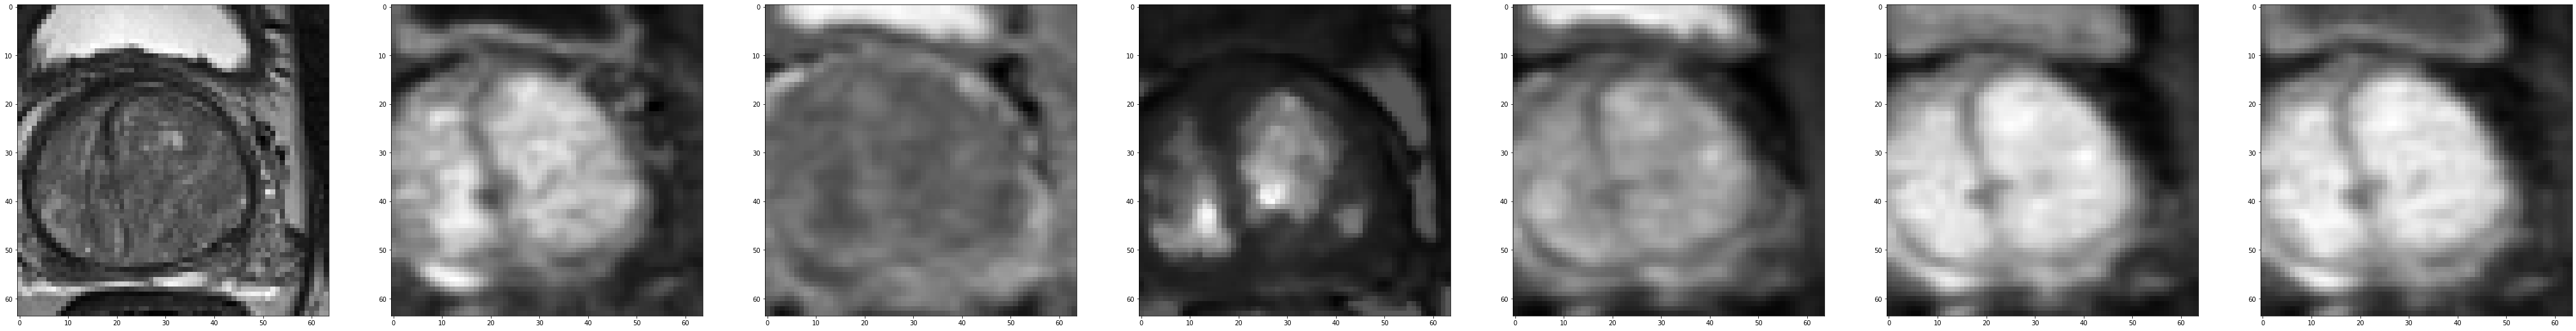

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 7, figsize=(72, 72))
for i in range(7):
    ax[i].imshow(dataset[100][0][i], cmap='gray')

In [41]:
torch.sigmoid(model(dataset[100][0].unsqueeze(0))).matmul(model.w_ensemble)

tensor([0.6683], grad_fn=<MvBackward>)